<a href="https://colab.research.google.com/github/IgorJoaquimn/webp-compression/blob/main/TP_ICV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Alunos:**
O objetivo deste trabalho é comprimir uma imagem passada como entrada. O método desenvolvido pode ser com ou sem perdas [reference](https://developers.google.com/speed/webp/docs/compression)

In [ ]:
import cv2
import numpy as np
from scipy import fftpack
import struct
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

## Funções Auxiliares


In [ ]:
# funções auxiliares
def show_image(image, title=""):
    """Display the image."""
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(title)
    # plt.show()


def get_2D_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def get_reconstructed_image(raw):
    img = raw.clip(0, 255)
    img = img.astype('uint8')
    img = Image.fromarray(img)
    return img

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

quantization_matrix = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61],
                                 [12, 12, 14, 19, 26, 58, 60, 55],
                                 [14, 13, 16, 24, 40, 57, 69, 56],
                                 [14, 17, 22, 29, 51, 87, 80, 62],
                                 [18, 22, 37, 56, 68, 109, 103, 77],
                                 [24, 35, 55, 64, 81, 104, 113, 92],
                                 [49, 64, 78, 87, 103, 121, 120, 101],
                                 [72, 92, 95, 98, 112, 100, 103, 99]])

In [ ]:
# Prediction Functions
def H_PRED(left_column, block_size):
    """Horizontal prediction mode."""
    return np.tile(left_column, (block_size, 1))

def V_PRED(above_row, block_size):
    """Vertical prediction mode."""
    return np.tile(above_row, (block_size, 1)).T

def DC_PRED(above_row, left_column, block_size):
    """DC prediction mode."""
    dc_value = int((np.sum(above_row) + np.sum(left_column)) / (2 * block_size))
    return np.full((block_size, block_size), dc_value)

def TM_PRED(above_row, left_column, above_left_pixel, block_size):
    """TrueMotion prediction mode."""
    pred_block = np.zeros((block_size, block_size))

    # Fill the first row using the above_row
    pred_block[0, :] = above_row[-block_size:]

    # Fill the first column using the left_column
    pred_block[:, 0] = left_column[-block_size:]

    # Fill the rest of the block using horizontal differences
    for i in range(1, block_size):
        for j in range(1, block_size):
            pred_block[i, j] = above_left_pixel + left_column[i] - above_row[j]

    return pred_block

prediction_functions = [H_PRED,V_PRED,DC_PRED,TM_PRED]

## Definição do Pipeline de Compressão
[macroblocks -> preditive pixel -> residuals-> transform coding DCT -> quantization -> Arithmetic entropy encoding]

* Algoritmo de predição retirado de
  *  C., Anil & da, Lavanya Vaishnavi. (2023). Intra Prediction Algorithm for Video Frames of H.264. 8. 11357-11367.

In [ ]:
def divide_into_macroblocks(height, width, block_size):
    """Divide the image into macroblocks of given size and return their coordinates."""
    macroblock_coords = []
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            macroblock_coords.append((y, x))
    return macroblock_coords

def predict_pixel(image, macroblock_coords, block_size=8):
    """Predict pixel values based on neighboring pixels and return the best prediction along with its encoded bytes."""
    # Extract coordinates
    y, x = macroblock_coords

    # Get neighboring pixels
    left_column = image[y:y+block_size, max(x-1, 0)]
    above_row = image[max(y-1, 0), x:x+block_size]
    above_left_pixel = image[max(y-1, 0), max(x-1, 0)]

    # Define prediction functions with their respective parameters and struct format strings
    prediction_functions = [
        (H_PRED,  (left_column, block_size),                             f">B {block_size*32}s "),
        (V_PRED,  (above_row, block_size),                               f">B {block_size*32}s "),
        (DC_PRED, (above_row, left_column, block_size),                  f">B {block_size*32}s {block_size*32}s"),
        (TM_PRED, (above_row, left_column, above_left_pixel, block_size),f">B {block_size*32}s {block_size*32}s")
    ]

    min_sad = float('inf')
    best_prediction = None
    best_prediction_function = None
    best_struct_format = None

    for i, (prediction_function, params, struct_format) in enumerate(prediction_functions):
        pred_block = prediction_function(*params)
        sad = np.sum(np.abs(image[y:y+block_size, x:x+block_size] - pred_block))
        if sad < min_sad:
            min_sad = sad
            best_prediction = pred_block
            best_prediction_function = prediction_functions[i]

    return best_prediction, best_prediction_function

def compute_residuals(original_macroblock, predicted_macroblock):
    """Compute the residuals (differences between original and predicted macroblocks)."""
    return original_macroblock - predicted_macroblock

def transform_coding_dct(residual_macroblock):
    """Apply Discrete Cosine Transform (DCT) to the residual macroblock."""
    return fftpack.dct(fftpack.dct(residual_macroblock.T, norm='ortho').T, norm='ortho')

def quantization(transformed_macroblock, quantization_matrix, block_size=8, coarse_threshold=100, fine_step=0.5, coarse_step=1):
    """Quantize the transformed macroblock with adaptive quantization."""
    height, width = transformed_macroblock.shape

    # Calculate the variance of the block
    variance = np.var(transformed_macroblock)

    # Choose quantization step size based on variance
    if variance < coarse_threshold:
        quantization_step = coarse_step  # Coarse quantization
    else:
        quantization_step = fine_step  # Fine quantization

    # Apply quantization matrix and adaptive quantization
    quantized_block = np.round(transformed_macroblock / (quantization_matrix * quantization_step))

    return quantized_block,quantization_step

def arithmetic_entropy_encoding(quantized_macroblock):
    """Encode the quantized macroblock using arithmetic entropy encoding."""
    # Flatten the quantized macroblock to a 1D array
    pass

# huffman
from heapq import heappush, heappop, heapify
from collections import defaultdict

def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))
    # return encoded_data

## Uso

In [ ]:
import requests

# URL of the Lena image
url = "https://thispersondoesnotexist.com/"
response = requests.get(url)
with open("lena512.pgm", 'wb') as f:
    f.write(response.content)

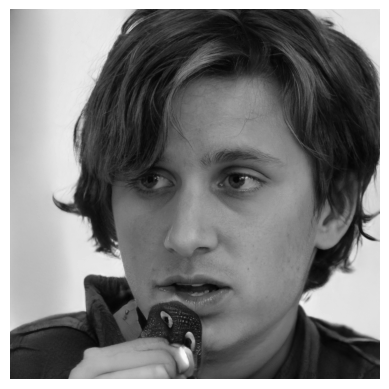

In [ ]:
image = cv2.imread('lena512.pgm',0)  # Example random image
image = image.astype(np.float32) - 128
show_image(image)

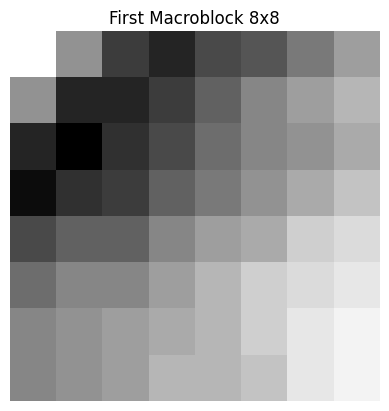

In [ ]:
height, width =  image.shape

block_size = 8

macroblocks = divide_into_macroblocks(height, width, block_size)
first_macroblock_coords = macroblocks[0]

# Extract the first macroblock from the original image using its coordinates
y, x = first_macroblock_coords
first_macroblock = image[y:y+block_size, x:x+block_size]

# Display the first macroblock
show_image(first_macroblock,"First Macroblock 8x8")

### Preditive Coding

(<function DC_PRED at 0x7814702071c0>, (array([13.,  4., -3., -5., -2., -1.,  2.,  5.], dtype=float32), array([13.,  4., -5., -7., -2.,  1.,  3.,  3.], dtype=float32), 8), '>B 256s 256s')


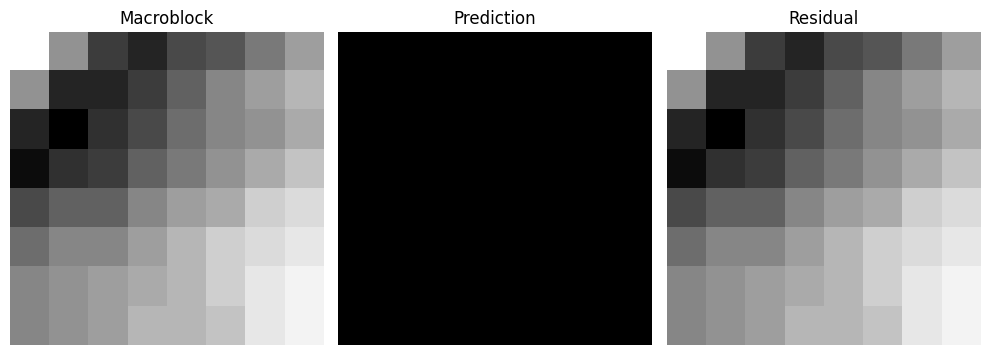

In [ ]:
best_prediction_first_macroblock,best_prediction_function  = predict_pixel(image,first_macroblock_coords,block_size=block_size)
print(best_prediction_function)
# Calculate the residual
residual = first_macroblock - best_prediction_first_macroblock

# Plot the macroblock, prediction, and residual side by side
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
show_image(first_macroblock, 'Macroblock')

plt.subplot(1, 3, 2)
show_image(best_prediction_first_macroblock, 'Prediction')

plt.subplot(1, 3, 3)
show_image(residual, 'Residual')

plt.tight_layout()
plt.show()

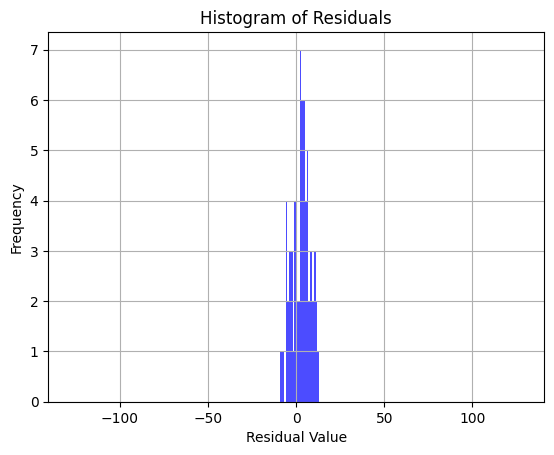

In [ ]:
# Plot histogram of residuals
plt.figure()
plt.hist(residual.flatten(), bins=256, range=(-128, 128), color='blue', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
transformed_residuals_macroblocks = []
residualss = []
header = []

for macroblock_coords in macroblocks:
  y, x = macroblock_coords
  macroblock = image[y:y+block_size, x:x+block_size]
  # Predict
  predicted_macroblock,best_prediction_function  = predict_pixel(image,macroblock_coords,block_size=block_size)

  # Calculate the residuals
  residuals = compute_residuals(macroblock, predicted_macroblock)
  residualss.append(residuals)

  # Transformation and Quantization
  transformed_residuals = transform_coding_dct(residuals)
  quantized_transformed_residuals, quantization_step = quantization(transformed_residuals, quantization_matrix)

  # Save in the matrix
  transformed_residuals_macroblocks.append(quantized_transformed_residuals)

  header.append(best_prediction_function + tuple([quantization_step]))

In [ ]:
def reconstruct_image(blocks, height, width, block_size):
    """Reconstruct the image based on the macroblocks."""
    macroblocks_coords = divide_into_macroblocks(height, width, block_size)
    reconstructed_image = np.zeros((height, width))

    for i,macroblock in enumerate(macroblocks_coords):
      y,x = macroblock
      reconstructed_image[y:y+block_size, x:x+block_size] = blocks[i]

    return reconstructed_image

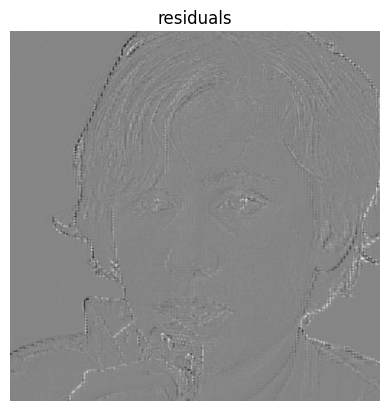

In [ ]:
reconstructed_image = reconstruct_image(residualss, height, width, block_size)
show_image(reconstructed_image, 'residuals')

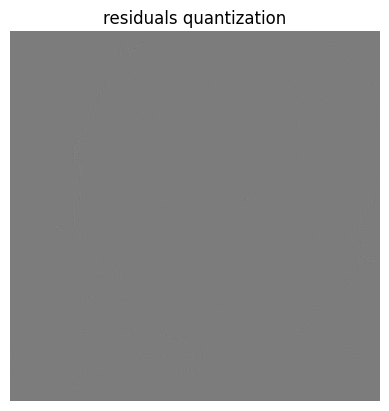

In [ ]:
reconstructed_image = reconstruct_image(transformed_residuals_macroblocks, height, width, block_size)
show_image(reconstructed_image, 'residuals quantization')

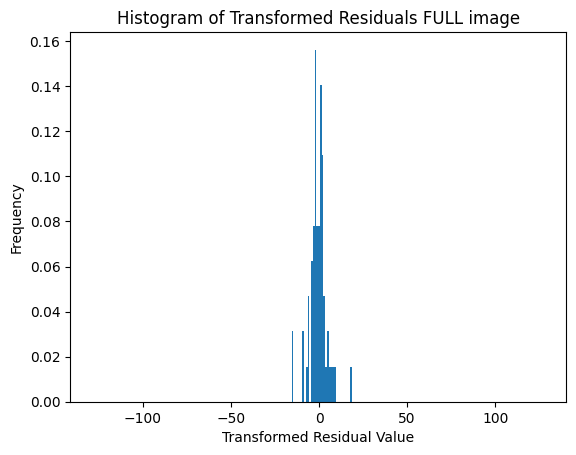

In [ ]:
# Compute histogram of transformed residuals
hist, bins = np.histogram(transformed_residuals, bins=256, range=(-128, 128))

# Normalize histogram to obtain frequencies
hist = hist / np.sum(hist)

# Plot histogram
plt.bar(bins[:-1], hist, width=1)
plt.title("Histogram of Transformed Residuals FULL image")
plt.xlabel("Transformed Residual Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Create dictionary mapping pixel intensity values to their frequencies
symb2freq = defaultdict(float)
for intensity, freq in enumerate(hist):
    symb2freq[intensity] = freq

huff = encode(symb2freq)

In [ ]:
nbits = 0
for i in range(0,256):
    nbits += len(huff[i][1]) * hist[huff[i][0]] * height * width

# bits per pixel
bpp = nbits / (height * width)

print ("\n",13*"-","Summary",13*"-")
print ("Original Size: %d bytes" % ((height * width) * 32))
print ("Residual size: %d bytes" % (nbits / 8))
print ("%5.3f bits/pixel" % bpp)
print ("Compression ratio (without header): %5.3f" % (8/bpp))


 ------------- Summary -------------
Original Size: 33554432 bytes
Residual size: 507904 bytes
3.875 bits/pixel
Compression ratio (without header): 2.065


## Decompressao


In [ ]:
def dequantization(residual_macroblock, quantization_matrix, step = 5):
    """Quantize the residual macroblock with adaptive quantization."""
    # Apply quantization matrix and adaptive quantization
    quantized_block = (quantization_matrix * step) * residual_macroblock

    return quantized_block

def transform_coding_idct(coefficients):
    """Apply Discrete Cosine Transform (DCT) to the residual macroblock."""

    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')


In [ ]:
macroblocks_coords = divide_into_macroblocks(height, width, block_size)

In [ ]:
decompress = []

for i,macroblock in enumerate(transformed_residuals_macroblocks):
  macroblock = transformed_residuals_macroblocks[i]
  preditive_f,params,_,step = header[i]

  # quantization
  dequantized_block = dequantization(macroblock,quantization_matrix,step)
  # inverse dct
  residual  = transform_coding_idct(dequantized_block)
  # preditive decoding
  predicted_block = preditive_f(*params)
  original = residual + predicted_block
  decompress.append(original)

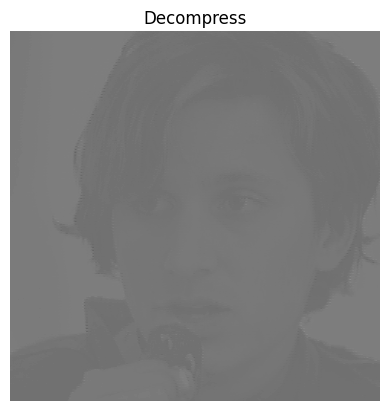

In [ ]:
reconstructed_image = reconstruct_image(decompress, height, width, block_size) + 128
show_image(reconstructed_image, 'Decompress')

In [ ]:
print ("RMSE: %5.3f" % rmse(image, reconstructed_image))
print ("PSNR: %5.3f" % psnr(image, reconstructed_image))

RMSE: 154.635
PSNR: 4.345
